In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from pathlib import Path
import glob
import os
import os.path
from sklearn.model_selection import train_test_split

In [2]:
path = Path('flowers')
images = list(path.glob(r'*/*.jpg'))
labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1],images))


images_series = pd.Series(images,name='image_path').astype(str)
labels_series = pd.Series(labels,name='labels')

data = pd.concat([images_series,labels_series],axis=1)

data = data.sample(frac=1).reset_index(drop=True)

X_train , X_test = train_test_split(data,test_size=0.2,shuffle=True,stratify=data.labels,random_state=17)

In [3]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(
        rescale = 1.0/255,
        shear_range = 0.3,
        zoom_range = 0.3,
        horizontal_flip = True,
        vertical_flip = True,
        rotation_range = 45,
        brightness_range = [0.5,1],
        width_shift_range=0.1,
        height_shift_range=0.1
)

test_datagen = keras.preprocessing.image.ImageDataGenerator(
        rescale = 1.0/255,
        validation_split = 0.4
)


train_data = train_datagen.flow_from_dataframe(
        dataframe = X_train,
        x_col = 'image_path',
        y_col = 'labels',
        batch_size = 64,
        target_size = (150,150),
        class_mode = 'categorical',
        color_mode = 'rgb',
        subset='training'
)

test_data = test_datagen.flow_from_dataframe(
    dataframe = X_test,
    x_col = 'image_path',
    y_col = 'labels',
    batch_size = 64,
    target_size = (150,150),
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle=False
)

val_data = test_datagen.flow_from_dataframe(
    dataframe = X_test,
    x_col = 'image_path',
    y_col = 'labels',
    batch_size = 64,
    target_size = (150,150),
    class_mode = 'categorical',
    color_mode = 'rgb',
    subset = 'validation'
)


Found 3453 validated image filenames belonging to 5 classes.
Found 864 validated image filenames belonging to 5 classes.
Found 345 validated image filenames belonging to 5 classes.


In [4]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,   
    patience=2, 
    min_lr=0.01,
    verbose=2
)

In [13]:
opti = keras.optimizers.Adam(learning_rate=0.01)
def my_learning_rate(epoch, lrate):
    if epoch%5 == 0 and epoch!=0:
        lrate = lrate * 0.2
    return lrate
 
lrs = keras.callbacks.LearningRateScheduler(my_learning_rate)
inception_v3 = keras.applications.inception_v3.InceptionV3(weights='imagenet',include_top=False)

x = inception_v3.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(512, activation='relu')(x)
predictions = keras.layers.Dense(5, activation='softmax')(x)

inception_v3_model = keras.models.Model(inputs=inception_v3.input, outputs=predictions)

for layer in inception_v3.layers:
    layer.trainable = False
    
inception_v3_model.compile(optimizer = opti,loss='categorical_crossentropy',metrics=['accuracy'])

inception_v3_history = inception_v3_model.fit(train_data,epochs=50,steps_per_epoch=54,validation_data=val_data,validation_steps=6,callbacks=[lrs])

Epoch 1/50
54/54 [==============================] - 19s 320ms/step - loss: 7.5916 - accuracy: 0.4900 - val_loss: 0.7907 - val_accuracy: 0.7130
Epoch 2/50
54/54 [==============================] - 16s 300ms/step - loss: 0.7352 - accuracy: 0.7275 - val_loss: 0.5859 - val_accuracy: 0.7913
Epoch 3/50
54/54 [==============================] - 16s 300ms/step - loss: 0.6406 - accuracy: 0.7669 - val_loss: 0.5525 - val_accuracy: 0.8203
Epoch 4/50
54/54 [==============================] - 16s 301ms/step - loss: 0.5983 - accuracy: 0.7842 - val_loss: 0.5319 - val_accuracy: 0.8261
Epoch 5/50
54/54 [==============================] - 16s 300ms/step - loss: 0.5768 - accuracy: 0.7918 - val_loss: 0.5767 - val_accuracy: 0.8029
Epoch 6/50
54/54 [==============================] - 16s 302ms/step - loss: 0.5090 - accuracy: 0.8167 - val_loss: 0.4770 - val_accuracy: 0.8290
Epoch 7/50
54/54 [==============================] - 16s 302ms/step - loss: 0.4860 - accuracy: 0.8199 - val_loss: 0.4703 - val_accuracy: 0.8435

In [18]:
inception_v3_model.save('inception_v3_model')

INFO:tensorflow:Assets written to: inception_v3_model\assets


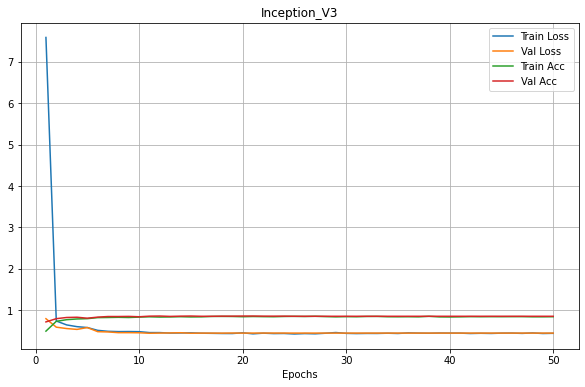

In [15]:
epochs = range(1, 51)
plt.figure(figsize=(10,6))
plt.plot(epochs, inception_v3_history.history['loss'], label='Train Loss')
plt.plot(epochs, inception_v3_history.history['val_loss'], label='Val Loss')
plt.plot(epochs, inception_v3_history.history['accuracy'], label='Train Acc')
plt.plot(epochs, inception_v3_history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epochs')
plt.title('Inception_V3')
plt.grid()
plt.legend()

plt.savefig('Inception_V3_plot.jpg',dpi=500)
plt.show()

# RESNET MODEL

In [10]:
opti = keras.optimizers.Adam(learning_rate=0.01)
def my_learning_rate(epoch, lrate):
    if epoch%3 == 0 and epoch!=0:
        lrate = lrate * 0.2
    return lrate
 
lrs = keras.callbacks.LearningRateScheduler(my_learning_rate)

resnet_152v2 = keras.applications.ResNet152V2(weights='imagenet',include_top=False)

x = resnet_152v2.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(512, activation='relu')(x)
predictions = keras.layers.Dense(5, activation='softmax')(x)

resnet_152v2_model = keras.models.Model(inputs=resnet_152v2.input, outputs=predictions)

for layer in resnet_152v2.layers:
    layer.trainable = False
    
resnet_152v2_model.compile(optimizer = opti,loss='categorical_crossentropy',metrics=['accuracy'])

resnet_152v2_history = resnet_152v2_model.fit(train_data,epochs=50,steps_per_epoch=54,validation_data=val_data,validation_steps=6,callbacks=[lrs])

Epoch 1/50
54/54 [==============================] - 23s 345ms/step - loss: 1.7622 - accuracy: 0.6612 - val_loss: 0.5020 - val_accuracy: 0.8319
Epoch 2/50
54/54 [==============================] - 17s 317ms/step - loss: 0.6025 - accuracy: 0.7712 - val_loss: 0.4688 - val_accuracy: 0.8609
Epoch 3/50
54/54 [==============================] - 17s 319ms/step - loss: 0.5367 - accuracy: 0.8045 - val_loss: 0.4668 - val_accuracy: 0.8435
Epoch 4/50
54/54 [==============================] - 17s 320ms/step - loss: 0.4756 - accuracy: 0.8233 - val_loss: 0.4045 - val_accuracy: 0.8725
Epoch 5/50
54/54 [==============================] - 18s 322ms/step - loss: 0.4339 - accuracy: 0.8448 - val_loss: 0.4134 - val_accuracy: 0.8725
Epoch 6/50
54/54 [==============================] - 18s 325ms/step - loss: 0.4216 - accuracy: 0.8436 - val_loss: 0.4175 - val_accuracy: 0.8667
Epoch 7/50
54/54 [==============================] - 18s 326ms/step - loss: 0.4067 - accuracy: 0.8494 - val_loss: 0.4057 - val_accuracy: 0.8667

In [17]:
resnet_152v2_model.save('resnet_152v2_model')

c:\users\athar\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: resnet_152v2_model\assets


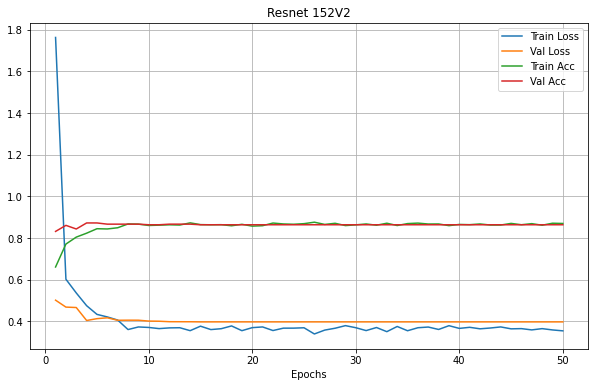

In [11]:
epochs = range(1,51)
plt.figure(figsize=(10,6))
plt.plot(epochs, resnet_152v2_history.history['loss'], label='Train Loss')
plt.plot(epochs, resnet_152v2_history.history['val_loss'], label='Val Loss')
plt.plot(epochs, resnet_152v2_history.history['accuracy'], label='Train Acc')
plt.plot(epochs, resnet_152v2_history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epochs')
plt.title('Resnet 152V2')
plt.grid()
plt.legend()

plt.savefig('Resnet 152V2_plot.jpg',dpi=500)
plt.show()